In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon
from scipy.spatial import distance
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
from scipy.stats import t
from pingouin import bayesfactor_ttest
from pingouin import compute_bootci
from pingouin import compute_effsize
from pingouin import power_ttest

clist = []
for cname in ["winter", "spring"]:
    c = cm.get_cmap(cname, 100)
    clist.append(ListedColormap(c(np.linspace(0, 1, 80))))

# Importing the data

In [2]:
#define paths
p = os.getcwd()
parent = os.path.dirname(p)
relative = "/data/"
path = parent+relative
fileExt = ".txt"
startStr1 = "jatos"
startStr2 = "study"
startStr3 = "comp"
# list the name of the files in the current folder
files = os.listdir(path)
DATA = []
for file in files:
    if file.startswith(startStr1):
        #print(file)
        subjectFiles = os.listdir(path+file)
        #print(subjectFiles)
        for subjectFile in subjectFiles:
            if subjectFile.startswith(startStr2):
                #print(subjectFile)
                subjectTxtFiles = os.listdir(path+file+"/"+subjectFile)
                #print(subjectTxtFiles)
                for subjectTxtFile in subjectTxtFiles:
                    if subjectTxtFile.startswith(startStr3):
                        fileName = os.listdir(path+file+"/"+subjectFile+"/"+subjectTxtFile)
                        #print(fileName)
                        # Load the JSON data from the text file
                        with open(path+file+"/"+subjectFile+"/"+subjectTxtFile+"/"+fileName[0], "r") as f:
                            json_data = json.load(f)
                        # Create a DataFrame from the JSON data
                        DATA.append([pd.DataFrame(json_data[cName]) for cName in json_data.keys()])
print(DATA[0][0].columns)

Index(['ID_name', 'block', 'color', 'condition', 'correct_keyboard_response',
       'number', 'practice', 'response_keyboard_response',
       'response_time_keyboard_response', 'subject_nr'],
      dtype='object')


# Looking at the training trials

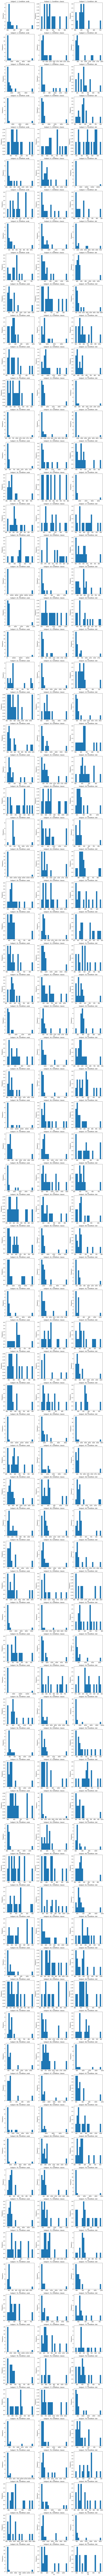

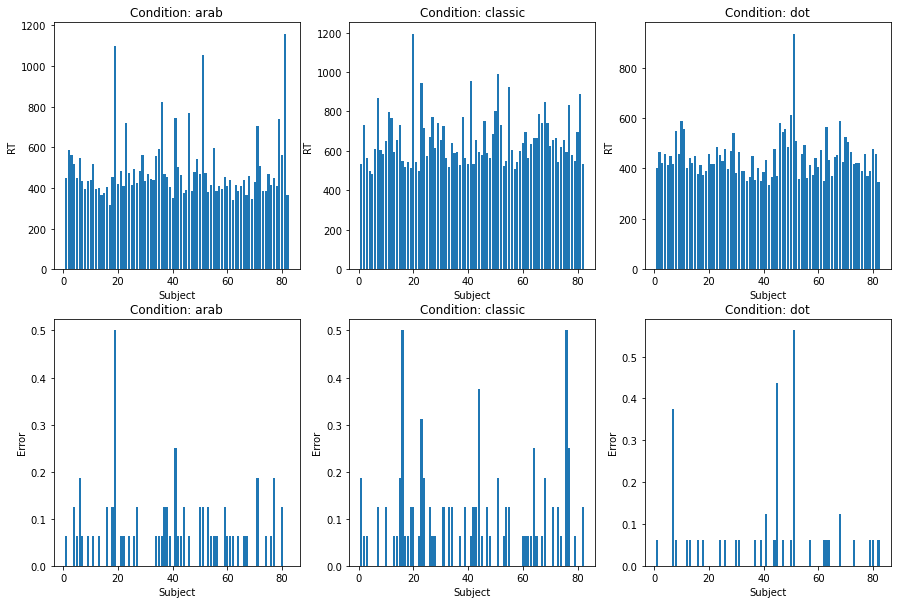

In [3]:
condType = np.unique(DATA[0][0]['condition'])
respType = np.unique(DATA[0][0]['response_keyboard_response'])
n,m = len(DATA), len(condType)
# saving the results for RT and Errors
practice_results = np.zeros((n, m, 2))
# plot the results
figRT, axRT = plt.subplots(n, m, figsize=(m*5,n*5))
axRT = axRT.flatten()
# looping over the subjects
for di, data in enumerate(DATA):
    data = data[0]
    practice_data = data[data['practice'] == "yes"]
    condType = np.unique(data['condition'])
    for ci, c in enumerate(condType):
        #print("Condition: ", c)
        cdata = practice_data[practice_data['condition'] == c]
        # create an RT and an error table
        RT = cdata
        Err = cdata 
        # remove error trials from RT table
        RT = RT[RT['correct_keyboard_response'] == 1]
        # compute correct response
        practice_results[di,ci,0] = np.median(RT['response_time_keyboard_response'])
        practice_results[di,ci,1] = 1-np.mean(Err['correct_keyboard_response'])
        # plot the results
        axRT[di*m+ci].hist(RT['response_time_keyboard_response'], bins=20)
        axRT[di*m+ci].set_title("Subject: "+str(di+1)+", Condition: "+c)
        axRT[di*m+ci].set_xlabel("RT")
        axRT[di*m+ci].set_ylabel("Frequency")
plt.show()

# plot the results
fig, ax = plt.subplots(2, m, figsize=(m*5,2*5))
ax = ax.flatten()
for ci, c in enumerate(condType):
    ax[ci].bar(np.arange(n)+1, practice_results[:,ci,0])
    ax[ci].set_title("Condition: "+c)
    ax[ci].set_xlabel("Subject")
    ax[ci].set_ylabel("RT")
    ax[ci+m].bar(np.arange(n)+1, practice_results[:,ci,1])
    ax[ci+m].set_title("Condition: "+c)
    ax[ci+m].set_xlabel("Subject")
    ax[ci+m].set_ylabel("Error")
plt.show()

        


# Excluding subjects with high error rates

Ghost classic 0.4910714285714286
Greenballs arab 0.19791666666666663
Greenballs classic 0.2276785714285714
AYDGHZ dot 0.5
asd15243 arab 0.5208333333333333
asd15243 classic 0.5089285714285714
asd15243 dot 0.25
rox2002 classic 0.1741071428571429


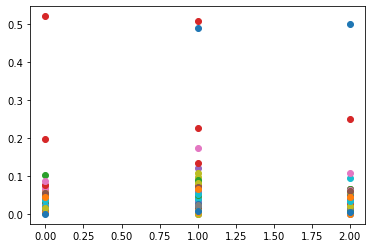

subjects excluded:  [['Ghost', 'Greenballs', 'Greenballs', 'AYDGHZ', 'asd15243', 'asd15243', 'asd15243', 'rox2002'], [20, 43, 43, 50, 63, 63, 63, 76]]
subjects included:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47 48 49
 51 52 53 54 55 56 57 58 59 60 61 62 64 65 66 67 68 69 70 71 72 73 74 75
 77 78 79 80 81]
Total number of subjects:  82
number of subjects included:  77


In [4]:
ERR = np.zeros((len(DATA), len(condType)))
outlier_ix = [[],[]]
for di, data in enumerate(DATA):
    data = data[0]
    data = data[data['practice'] == "no"]
    #display(data.head())
    for ci, c in enumerate(condType):
        #print("Condition: ", c)
        cdata = data[data['condition'] == c]
        # summary stat on Errors
        ERR[di,ci] = 1-np.mean(cdata['correct_keyboard_response'])
        if ERR[di,ci] > 0.15:
            outlier_ix[1].append(di)
            outlier_ix[0].append(DATA[di][0]['ID_name'][0])
            print(DATA[di][0]['ID_name'][0], c, ERR[di,ci])
plt.plot(ERR.T, "o")
plt.show()
# 15 % error rate should be the threshold
#ix = np.unique(np.where(ERR>0.99)[0]) # numpy messes up the indices
print("subjects excluded: ", outlier_ix)
# remaining subjects
included_ix = np.setdiff1d(np.arange(len(DATA)), np.unique(outlier_ix[1]))
print("subjects included: ", included_ix)
print("Total number of subjects: ", len(DATA))
DATA = [DATA[i] for i in included_ix]
N = len(DATA)
print("number of subjects included: ", N)


# Analyzing the SNARC effects in the three conditions

In [5]:
def linReg(xT,yT):
    return np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(xT),xT)),np.transpose(xT)), yT)

In [6]:
# predictiors for the regression
Xs = np.unique(data['number'])
xT = np.stack((np.ones(len(Xs)), Xs), axis=-1)
# saving the results for RT
D = {"classic": 
            {"left": {"RT": np.zeros((len(DATA), 8)), "count": np.zeros((len(DATA), 8)), "reg": np.zeros((len(DATA), 2))}, 
             "right": {"RT": np.zeros((len(DATA), 8)), "count": np.zeros((len(DATA), 8)), "reg": np.zeros((len(DATA), 2))}},
        "arab": 
            {"left": {"RT": np.zeros((len(DATA), 8)), "count": np.zeros((len(DATA), 8)), "reg": np.zeros((len(DATA), 2))}, 
             "right": {"RT": np.zeros((len(DATA), 8)), "count": np.zeros((len(DATA), 8)), "reg": np.zeros((len(DATA), 2))}},
        "dot": 
            {"left": {"RT": np.zeros((len(DATA), 8)), "count": np.zeros((len(DATA), 8)), "reg": np.zeros((len(DATA), 2))}, 
             "right": {"RT": np.zeros((len(DATA), 8)), "count": np.zeros((len(DATA), 8)), "reg": np.zeros((len(DATA), 2))}},}
# looping over the subjects
for di, data in enumerate(DATA):
    data = data[0]
    # removing the training trials
    data = data[data['practice'] == "no"]
    # splitting the data into three conditions
    for ci, c in enumerate(condType):
        print("Condition: ", c)
        cdata = data[data['condition'] == c]
        # create an RT and an error table
        RT = cdata
        # remove error trials from RT table
        RT = RT[RT['correct_keyboard_response'] == 1]
        RT_left = RT[RT['response_keyboard_response'] == 'lshift']
        RT_right = RT[RT['response_keyboard_response'] == 'rshift']
        # create a pivot table to get the median of the response times for each numbers
        for rt,rl in zip([RT_left, RT_right],["left","right"]):
            pivotRT_count = pd.pivot_table(rt, index=['ID_name'], columns=['number','response_keyboard_response'], values=['subject_nr'], aggfunc='count')
            #display(pivotRT_count)
            pivotRT = pd.pivot_table(rt, index=['ID_name'], columns=['number','response_keyboard_response'], values=['response_time_keyboard_response'], aggfunc=[np.median])
            #display(pivotRT)
            D[c][rl]["count"][di,:] = pivotRT_count.values[0]
            D[c][rl]["RT"][di,:] = pivotRT.values[0]
            #print(pivotRT_count.values[0])
            D[c][rl]["reg"][di,:] = linReg(xT, pivotRT.values[0])

Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition:  dot
Condition:  arab
Condition:  classic
Condition

[4.34055736e+02 3.54112554e-01]


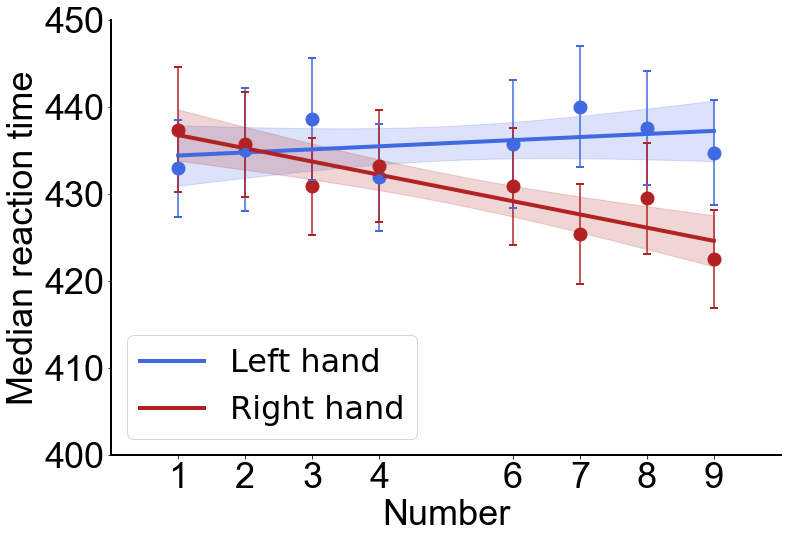

[541.25919913   5.76147186]


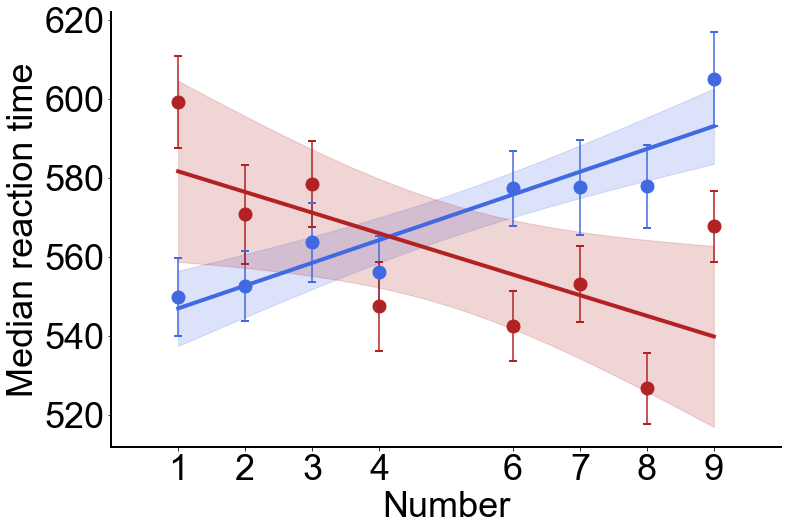

[411.88149351   2.05876623]


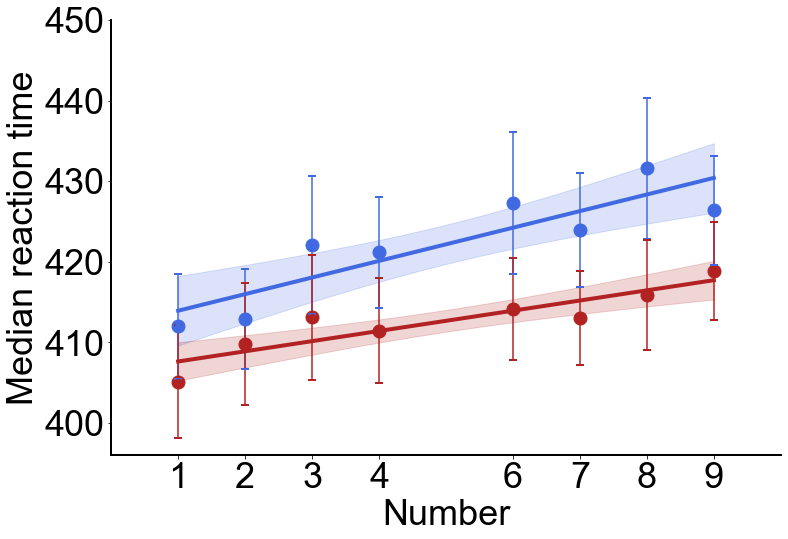

In [7]:
font = {"fontname": "Arial", "size": 36}
line_w = 2
colors_names = ["royalblue", "olivedrab", "darkorange", "firebrick"]
# Define confidence level and calculate critical value
confidence_level = 0.95  # 95% confidence interval
alpha = 1 - confidence_level
t_critical = t.ppf(1 - alpha / 2, df=N-2)  # Two-tailed t-score
ytck = [[400,410,420,430,440,450],[520,540,560,580,600,620],[400,410,420,430,440,450]]
x_range = np.linspace(min(Xs), max(Xs), 100)
for ci, c in enumerate(condType):
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    mL = np.mean(D[c]["left"]["RT"],axis=0)
    ax.plot(Xs, mL, "o", color=colors_names[0], markersize=13, linewidth=line_w+2)
    mR = np.mean(D[c]["right"]["RT"],axis=0)
    ax.plot(Xs, mR, "o", color=colors_names[-1], markersize=13, linewidth=line_w+2)
    y_semL = np.std(D[c]["left"]["RT"],axis=0) / np.sqrt(N)
    y_semR = np.std(D[c]["right"]["RT"],axis=0) / np.sqrt(N)
    ax.errorbar(Xs, mL,  yerr=y_semL, fmt='o',capsize=4, capthick=2, color=colors_names[0])
    ax.errorbar(Xs, mR, yerr=y_semR, fmt='o',capsize=4, capthick=2, color=colors_names[-1])
    r = np.mean(D[c]["left"]["reg"],axis=0)
    print(r)
    # Calculate standard error of the estimate
    y_pred = Xs*r[1] + r[0]
    residuals = mL - y_pred
    std_error_estimate = np.sqrt(np.sum(residuals**2) / (len(Xs) - 2))
    x_mean = np.mean(Xs)
    x_deviation = x_range - x_mean
    x_sum_squares = np.sum((Xs - x_mean)**2)
    margin_of_error = t_critical * std_error_estimate * np.sqrt(1/len(Xs) + (x_deviation**2) / x_sum_squares)
    y_upper = r[0] + r[1] * x_range + margin_of_error
    y_lower = r[0] + r[1] * x_range - margin_of_error

    ax.plot(Xs, Xs*r[1] + r[0], "-", color=colors_names[0], linewidth=line_w+2, label="Left hand")
    ax.fill_between(x_range, y_lower, y_upper, color=colors_names[0], alpha=0.19)
    r = np.mean(D[c]["right"]["reg"],axis=0)
    # Calculate standard error of the estimate
    y_pred = Xs*r[1] + r[0]
    residuals = mR - y_pred
    std_error_estimate = np.sqrt(np.sum(residuals**2) / (len(Xs)- 2))
    x_mean = np.mean(Xs)
    x_deviation = x_range - x_mean
    x_sum_squares = np.sum((Xs - x_mean)**2)
    margin_of_error = t_critical * std_error_estimate * np.sqrt(1/len(Xs) + (x_deviation**2) / x_sum_squares)
    y_upper = r[0] + r[1] * x_range + margin_of_error
    y_lower = r[0] + r[1] * x_range - margin_of_error
    ax.plot(Xs, Xs*r[1] + r[0], "-", color=colors_names[-1], linewidth=line_w+2, label="Right hand")
    ax.fill_between(x_range, y_lower, y_upper, color=colors_names[-1], alpha=0.19)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(line_w)
    ax.spines["bottom"].set_linewidth(line_w)
    ax.spines["left"].set_linewidth(line_w)
    ax.grid(False)
    for label in (ax.get_xticklabels()+ax.get_yticklabels()):
        label.set_fontname(font["fontname"])
        label.set_fontsize(font["size"])
    # if c=="dot":
    #     ax.xaxis.set_ticklabels(["5(1)", "10(2)", "15(3)", "20(4)",  "30(6)", "35(7)", "40(8)", "45(9)"])
    ax.xaxis.set_ticks(Xs)
    #ax.xaxis.set_ticklabels([" " for _ in X])
    ax.set_xlim(0, Xs[-1]+1)
    ax.yaxis.set_ticks(ytck[ci])
    ax.set_xlabel("Number", **font)

    #ax0.set_ylabel("Normalized\n firing rate", **f_font2)
    ax.set_ylabel('Median reaction time', **font)
    if ci==0:
        ax.legend(loc="best", fontsize=32)
    #plt.tight_layout(pad=0, h_pad=-3)
    plt.savefig("L-R_mRT"+str(c)+".pdf")
    plt.show()

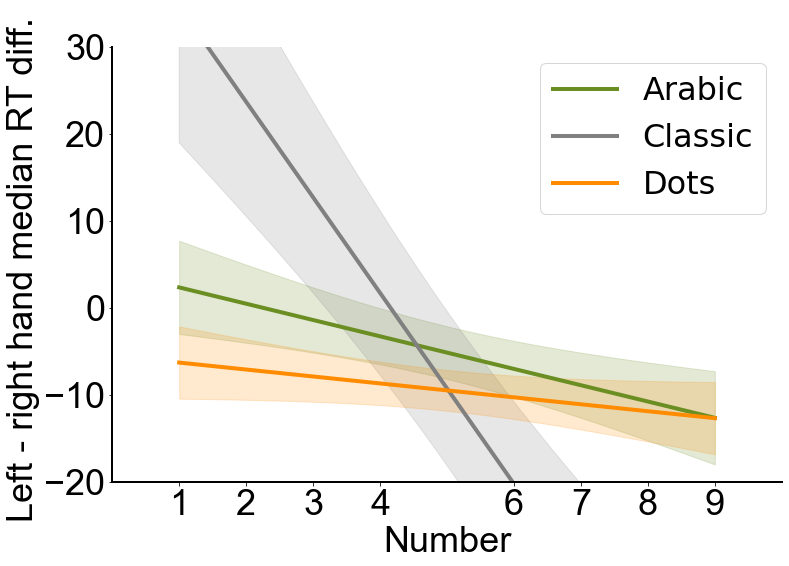

In [8]:
lbl = [ "Arabic", "Classic", "Dots"]
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ytck = [-20,-10,0,10,20,30]
colors_names = ["olivedrab", "gray","darkorange"]
for ci, c in enumerate(condType):
    mL = np.mean(D[c]["left"]["RT"],axis=0)
    mR = np.mean(D[c]["right"]["RT"],axis=0)
    rL = np.mean(D[c]["left"]["reg"],axis=0)
    rR = np.mean(D[c]["right"]["reg"],axis=0)
    s, b = (rR[1]-rL[1]), (rR[0]-rL[0])
    y_pred = Xs*s + b
    residuals = (mR-mL) - y_pred
    std_error_estimate = np.sqrt(np.sum(residuals**2) / (len(Xs) - 2))
    x_mean = np.mean(Xs)
    x_deviation = x_range - x_mean
    x_sum_squares = np.sum((Xs - x_mean)**2)
    margin_of_error = t_critical * std_error_estimate * np.sqrt(1/len(Xs) + (x_deviation**2) / x_sum_squares)
    y_upper = b + s * x_range + margin_of_error
    y_lower = b + s * x_range - margin_of_error
    ax.plot(Xs, Xs*s + b, "-", color=colors_names[ci], linewidth=line_w+2, label=lbl[ci])
    ax.fill_between(x_range, y_lower, y_upper, color=colors_names[ci], alpha=0.19)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(line_w)
ax.spines["bottom"].set_linewidth(line_w)
ax.spines["left"].set_linewidth(line_w)
ax.grid(False)
for label in (ax.get_xticklabels()+ax.get_yticklabels()):
    label.set_fontname(font["fontname"])
    label.set_fontsize(font["size"])
ax.xaxis.set_ticks(Xs)
#ax.xaxis.set_ticklabels([" " for _ in X])
ax.set_xlim(0, Xs[-1]+1)
ax.set_ylim(-11, 11)
ax.yaxis.set_ticks(ytck)
ax.set_xlabel("Number", **font)
#ax0.set_ylabel("Normalized\n firing rate", **f_font2)
ax.set_ylabel('Left - right hand median RT diff. ', **font)
ax.legend(loc="best", fontsize=32)
#plt.tight_layout(pad=0, h_pad=-3)
plt.savefig("diff_SNARCIndex.pdf")
plt.show()

In [9]:
[np.max(i) for i in s]

TypeError: 'numpy.float64' object is not iterable

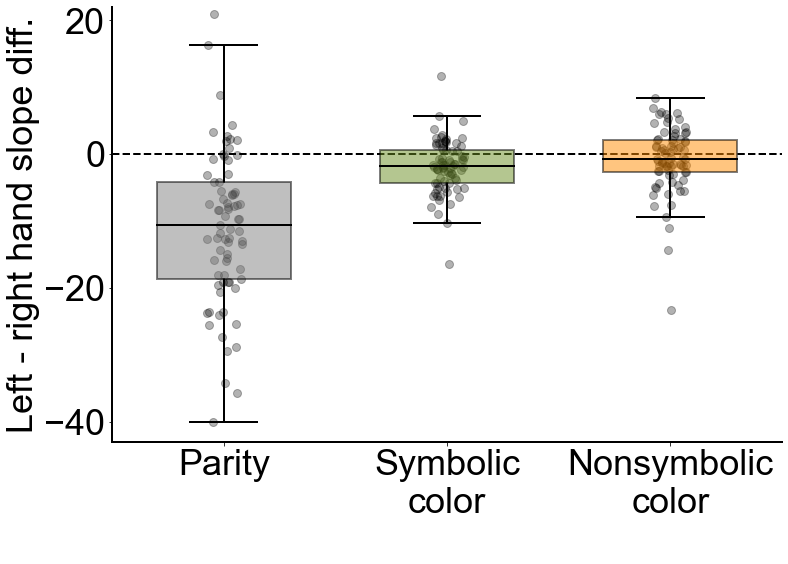

In [10]:
lbl = [ "Parity","Symbolic\ncolor","Nonsymbolic\ncolor"]
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ytck = [-40,-20,0,20,40]
colors_names = ["gray", "olivedrab", "darkorange"]
wd = 0.7
s=[]
half_range = 0.08
for ci, c in enumerate([condType[1], condType[0], condType[2]]):
    rL = D[c]["left"]["reg"][:,1]
    rR = D[c]["right"]["reg"][:,1]
    s.append(rR-rL)

#parts = ax.violinplot(s, showmedians=True, quantiles=[[0.25,0.75],[0.25,0.75],[0.25,0.75]], widths=wd)
bplot = ax.boxplot(s, widths=0.6, showfliers=False, patch_artist=True)
# for pi,pc in enumerate(parts['bodies']):
#    pc.set_facecolor(colors_names[pi])
#    pc.set_edgecolor(colors_names[pi])
#    pc.set_alpha(0.47)

# for partname in ('cbars','cmins','cmaxes','cmedians','cquantiles'):
#     vp = parts[partname]
#     vp.set_edgecolor("k")
#     vp.set_linewidth(2.5)

# for partname in ('cmedians','cquantiles'):
#     vp = parts[partname]

for patch, color in zip(bplot['boxes'], colors_names):
    patch.set_facecolor(color)
    patch.set_edgecolor("k")
    patch.set_linewidth(2)
    patch.set_alpha(0.5)
for w in bplot['whiskers']:
    w.set_color("k")
    w.set_linewidth(2)
for w in bplot['caps']:
    w.set_color("k")
    w.set_linewidth(2)
for w in bplot['medians']:
    w.set_color("k")
    w.set_linewidth(2)
ax.plot(np.random.uniform(low=1-half_range, high=1+half_range, size=N), s[0], "o", color="k", markersize=8, alpha=0.3)
ax.plot(np.random.uniform(low=2-half_range, high=2+half_range, size=N), s[1], "o", color="k", markersize=8,alpha=0.3)
ax.plot(np.random.uniform(low=3-half_range, high=3+half_range, size=N), s[2], "o", color="k", markersize=8,alpha=0.3)
# wd=0.17
# ax.plot([1+wd,1+wd], [np.percentile(s[0],25), np.percentile(s[0],75)], "-", color="grey", linewidth=line_w)
# ax.plot([1-wd,1-wd], [np.percentile(s[0],25), np.percentile(s[0],75)], "-", color="grey", linewidth=line_w)
# ax.plot([2+wd,2+wd], [np.percentile(s[1],25), np.percentile(s[1],75)], "-", color="grey", linewidth=line_w)
# ax.plot([2-wd,2-wd], [np.percentile(s[1],25), np.percentile(s[1],75)], "-", color="grey", linewidth=line_w)
# ax.plot([3+wd,3+wd], [np.percentile(s[2],25), np.percentile(s[2],75)], "-", color="grey", linewidth=line_w)
# ax.plot([3-wd,3-wd], [np.percentile(s[2],25), np.percentile(s[2],75)], "-", color="grey", linewidth=line_w)

ax.plot(np.linspace(0.5,3.5,10), np.zeros(10), "--", color="k", linewidth=line_w)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(line_w)
ax.spines["bottom"].set_linewidth(line_w)
ax.spines["left"].set_linewidth(line_w)
ax.grid(False)
for label in (ax.get_xticklabels()+ax.get_yticklabels()):
    label.set_fontname(font["fontname"])
    label.set_fontsize(font["size"])
ax.set_xticks([1,2,3])
ax.set_xticklabels(lbl)
ax.set_xlim(0.5,3.5)

ax.yaxis.set_ticks(ytck)
ax.set_ylim(-43, 22)
ax.set_xlabel(" ", **font)
ax.set_ylabel("Left - right hand slope diff.", **font)
#ax.legend(loc="best", fontsize=32)
#plt.tight_layout(pad=0, h_pad=-3)
plt.savefig("slopes_box.pdf")
plt.show()

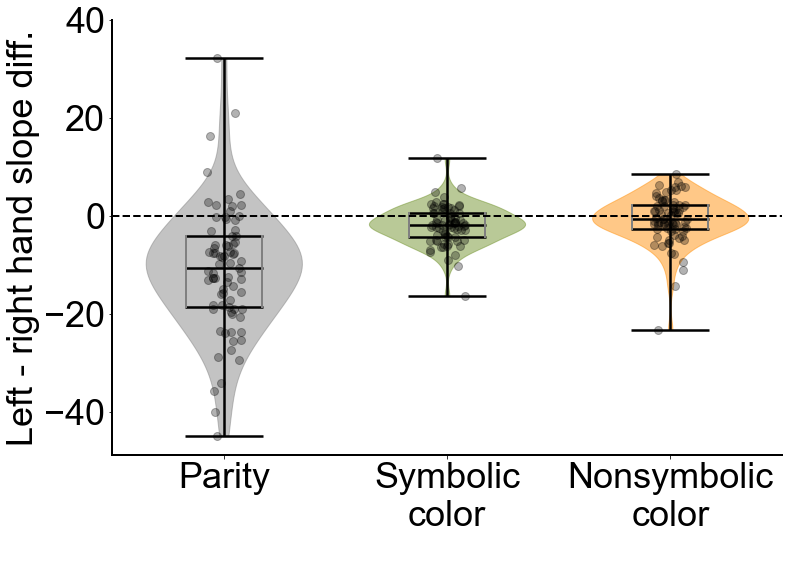

In [17]:
lbl = [ "Parity","Symbolic\ncolor","Nonsymbolic\ncolor"]
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ytck = [-40,-20,0,20,40]
colors_names = ["gray", "olivedrab", "darkorange"]
wd = 0.7
s=[]
half_range = 0.08
for ci, c in enumerate([condType[1], condType[0], condType[2]]):
    rL = D[c]["left"]["reg"][:,1]
    rR = D[c]["right"]["reg"][:,1]
    s.append(rR-rL)

parts = ax.violinplot(s, showmedians=True, quantiles=[[0.25,0.75],[0.25,0.75],[0.25,0.75]], widths=wd)
#bplot = ax.boxplot(s, widths=0.6, showfliers=False, patch_artist=True)
for pi,pc in enumerate(parts['bodies']):
   pc.set_facecolor(colors_names[pi])
   pc.set_edgecolor(colors_names[pi])
   pc.set_alpha(0.47)

for partname in ('cbars','cmins','cmaxes','cmedians','cquantiles'):
    vp = parts[partname]
    vp.set_edgecolor("k")
    vp.set_linewidth(2.5)

for partname in ('cmedians','cquantiles'):
    vp = parts[partname]

# for patch, color in zip(bplot['boxes'], colors_names):
#     patch.set_facecolor(color)
#     patch.set_edgecolor("k")
#     patch.set_linewidth(2)
#     patch.set_alpha(0.5)
# for w in bplot['whiskers']:
#     w.set_color("k")
#     w.set_linewidth(2)
# for w in bplot['caps']:
#     w.set_color("k")
#     w.set_linewidth(2)
# for w in bplot['medians']:
#     w.set_color("k")
#     w.set_linewidth(2)
ax.plot(np.random.uniform(low=1-half_range, high=1+half_range, size=N), s[0], "o", color="k", markersize=8, alpha=0.3)
ax.plot(np.random.uniform(low=2-half_range, high=2+half_range, size=N), s[1], "o", color="k", markersize=8,alpha=0.3)
ax.plot(np.random.uniform(low=3-half_range, high=3+half_range, size=N), s[2], "o", color="k", markersize=8,alpha=0.3)
wd=0.17
ax.plot([1+wd,1+wd], [np.percentile(s[0],25), np.percentile(s[0],75)], "-", color="grey", linewidth=line_w)
ax.plot([1-wd,1-wd], [np.percentile(s[0],25), np.percentile(s[0],75)], "-", color="grey", linewidth=line_w)
ax.plot([2+wd,2+wd], [np.percentile(s[1],25), np.percentile(s[1],75)], "-", color="grey", linewidth=line_w)
ax.plot([2-wd,2-wd], [np.percentile(s[1],25), np.percentile(s[1],75)], "-", color="grey", linewidth=line_w)
ax.plot([3+wd,3+wd], [np.percentile(s[2],25), np.percentile(s[2],75)], "-", color="grey", linewidth=line_w)
ax.plot([3-wd,3-wd], [np.percentile(s[2],25), np.percentile(s[2],75)], "-", color="grey", linewidth=line_w)

ax.plot(np.linspace(0.5,3.5,10), np.zeros(10), "--", color="k", linewidth=line_w)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(line_w)
ax.spines["bottom"].set_linewidth(line_w)
ax.spines["left"].set_linewidth(line_w)
ax.grid(False)
for label in (ax.get_xticklabels()+ax.get_yticklabels()):
    label.set_fontname(font["fontname"])
    label.set_fontsize(font["size"])
ax.set_xticks([1,2,3])
ax.set_xticklabels(lbl)
ax.set_xlim(0.5,3.5)
#ax.set_ylim(-11, 11)
ax.yaxis.set_ticks(ytck)
ax.set_xlabel(" ", **font)
ax.set_ylabel("Left - right hand slope diff.", **font)
#ax.legend(loc="best", fontsize=32)
#plt.tight_layout(pad=0, h_pad=-3)
plt.savefig("slopesViolin_box1.pdf")
plt.show()

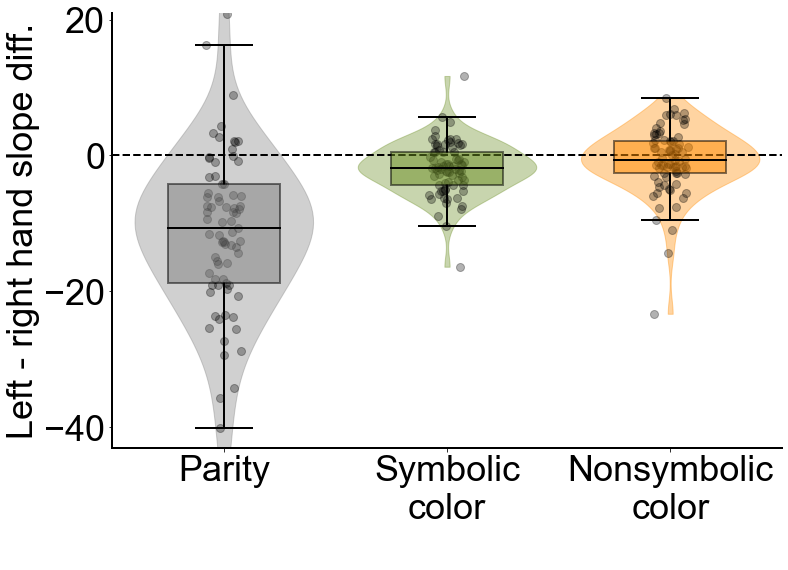

In [18]:
lbl = [ "Parity","Symbolic\ncolor","Nonsymbolic\ncolor"]
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ytck = [-40,-20,0,20,40]
colors_names = ["gray", "olivedrab", "darkorange"]
s=[]
half_range = 0.08
for ci, c in enumerate([condType[1], condType[0], condType[2]]):
    rL = D[c]["left"]["reg"][:,1]
    rR = D[c]["right"]["reg"][:,1]
    s.append(rR-rL)

parts = ax.violinplot(s, showmeans=False, showmedians=False, showextrema=False, widths=0.8)
bplot = ax.boxplot(s, widths=0.5, showfliers=False, patch_artist=True)
for pi,pc in enumerate(parts['bodies']):
   pc.set_facecolor(colors_names[pi])
   pc.set_edgecolor(colors_names[pi])
   pc.set_alpha(0.37)

# for partname in ('cbars','cmins','cmaxes','cmedians','cquantiles'):
#     vp = parts[partname]
#     vp.set_edgecolor("k")
#     vp.set_linewidth(3)

for patch, color in zip(bplot['boxes'], colors_names):
    patch.set_facecolor(color)
    patch.set_edgecolor("k")
    patch.set_linewidth(2)
    patch.set_alpha(0.5)
for w in bplot['whiskers']:
    w.set_color("k")
    w.set_linewidth(2)
for w in bplot['caps']:
    w.set_color("k")
    w.set_linewidth(2)
for w in bplot['medians']:
    w.set_color("k")
    w.set_linewidth(2)
ax.plot(np.random.uniform(low=1-half_range, high=1+half_range, size=N), s[0], "o", color="k", markersize=8, alpha=0.3)
ax.plot(np.random.uniform(low=2-half_range, high=2+half_range, size=N), s[1], "o", color="k", markersize=8,alpha=0.3)
ax.plot(np.random.uniform(low=3-half_range, high=3+half_range, size=N), s[2], "o", color="k", markersize=8,alpha=0.3)

ax.plot(np.linspace(0.5,3.5,10), np.zeros(10), "--", color="k", linewidth=line_w)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(line_w)
ax.spines["bottom"].set_linewidth(line_w)
ax.spines["left"].set_linewidth(line_w)
ax.grid(False)
for label in (ax.get_xticklabels()+ax.get_yticklabels()):
    label.set_fontname(font["fontname"])
    label.set_fontsize(font["size"])
ax.set_xticks([1,2,3])
ax.set_xticklabels(lbl)
ax.set_xlim(0.5,3.5)
ax.yaxis.set_ticks(ytck)
ax.set_ylim(-43, 21)

ax.set_xlabel(" ", **font)
ax.set_ylabel("Left - right hand slope diff.", **font)
#ax.legend(loc="best", fontsize=32)
#plt.tight_layout(pad=0, h_pad=-3)
plt.savefig("slopesViolin_box2.pdf")
plt.show()





In [19]:
[print(ttest_1samp(s[i],0)) for i in range(3)]
[print(wilcoxon(s[i])) for i in range(3)]
[print(bayesfactor_ttest(ttest_1samp(s[i],0)[0], N, paired=True)) for i in range(3)]

# excluding outliers
thr = 2.5
for ci,c in enumerate(condType):
    med = np.median(s[ci])
    MAD = thr*np.median(np.abs(s[ci] - med)) / 0.6744897501960817
    y = s[ci][(s[ci] < (med + MAD)) & (s[ci] > (med - MAD))]
    print(ttest_1samp(y,0))
    print(wilcoxon(y))
    print(bayesfactor_ttest(ttest_1samp(y,0)[0], len(y), paired=True))
    print(len(y))
# sima index
# outlier szures
# median +- 2.5 med
# dual index - 2 d ben
# mahalonobis distance; 2d; and cases beyond the .05 chi squared cut-off will be excluded
# plus Bayes factor
# slp -ok differenciajaval kiszamolni hogy teljesen ugyanaz legyen

Ttest_1sampResult(statistic=-7.595256532383435, pvalue=6.530795499739232e-11)
Ttest_1sampResult(statistic=-4.148728945075028, pvalue=8.63078095147951e-05)
Ttest_1sampResult(statistic=-1.4186210195542686, pvalue=0.16009744921194932)
WilcoxonResult(statistic=288.0, pvalue=7.20562576660859e-10)
WilcoxonResult(statistic=695.0, pvalue=4.222100812229296e-05)
WilcoxonResult(statistic=1318.0, pvalue=0.35148373366925345)
145053589.29549986
230.5223202903546
0.327776130041204
Ttest_1sampResult(statistic=-9.41739667394325, pvalue=3.505984076630307e-14)
WilcoxonResult(statistic=152.0, pvalue=4.433332092334037e-11)
208576145992.39777
73
Ttest_1sampResult(statistic=-4.903768262508873, pvalue=5.413001186356949e-06)
WilcoxonResult(statistic=619.0, pvalue=2.079969217986173e-05)
3056.8522889637484
75
Ttest_1sampResult(statistic=-0.39634213768430876, pvalue=0.6930088244256369)
WilcoxonResult(statistic=1318.0, pvalue=0.7080971493874202)
0.13796035000190196
74


In [20]:
print(ttest_1samp(s[1]-s[2],0))
print(wilcoxon(s[1]-s[2]))
print(bayesfactor_ttest(ttest_1samp(s[1]-s[2],0)[0], N, paired=True))

# excluding outliers
thr = 2.5
y = []

med = np.median(s[2])
MAD = thr*np.median(np.abs(s[2] - med)) / 0.6744897501960817
y.append(s[0][(s[1] < (med + MAD)) & (s[1] > (med - MAD))])
y.append(s[2][(s[2] < (med + MAD)) & (s[2] > (med - MAD))])
print(ttest_1samp(y[0]-y[1],0))
print(wilcoxon(y[0]-y[1]))
print(bayesfactor_ttest(ttest_1samp(y[0]-y[1],0)[0], len(y[0]-y[1]), paired=True))
print(len(y[0]-y[1]))

Ttest_1sampResult(statistic=-1.5725098360261336, pvalue=0.11998648599454802)
WilcoxonResult(statistic=1025.0, pvalue=0.015545578201909493)
0.4068825993553047
Ttest_1sampResult(statistic=-6.492048152474649, pvalue=8.976777767600217e-09)
WilcoxonResult(statistic=304.0, pvalue=5.312674032959939e-09)
1309163.873803692
74


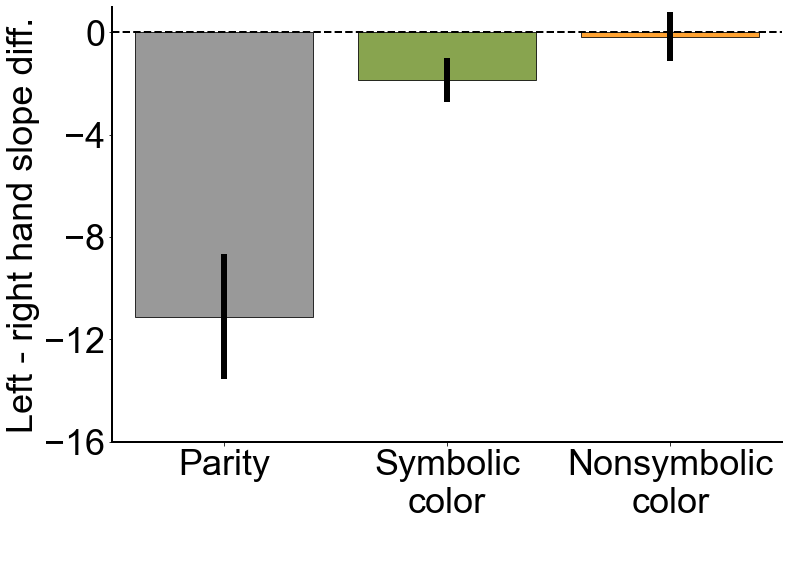

[-11.146575342465754, -1.8619999999999992, -0.17319819819819735]
[array([-13.42,  -8.79]), array([-2.59, -1.12]), array([-1.  ,  0.69])]
[-1.5006954716230827, -0.7450380862868161, -0.06841310821565705]
[-0.6028254500997904, -0.35114611202632323, -0.03441964184444733]
[1.0, 1.0, 0.08945314193197332]
no filtering
[-10.98398268  -1.8745671   -0.79891775]
[array([-13.76,  -8.18]), array([-2.76, -0.99]), array([-1.99,  0.23])]
[-1.2927507352785517, -0.6793372342744765, -0.26232396832325994]
[-0.5453500641586252, -0.32351038950432676, -0.13088633637047006]
[1.0, 0.9999565114806808, 0.6227801260892234]


In [21]:
lbl = [ "Parity","Symbolic\ncolor","Nonsymbolic\ncolor"]
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ytck = [-16,-12,-8,-4,0]
colors_names = [ "gray","olivedrab","darkorange"]
s, bCI, eff1, eff2, pow =[],[],[], [], []
s0, bCI0, eff10, eff20,pow0 =[],[],[], [], []
half_range = 0.05
for ci, c in enumerate([condType[1], condType[0], condType[2]]):
    rL0 = D[c]["left"]["reg"][:,1]
    rR0 = D[c]["right"]["reg"][:,1]
    s0.append(rR0-rL0)
    bCI0.append(compute_bootci(rR0-rL0, func='mean', n_boot=10000, method='cper'))
    eff10.append(compute_effsize(rR0, rL0, paired=True, eftype='cohen'))
    eff20.append(compute_effsize(rR0, rL0, paired=True, eftype='pointbiserialr'))
    pow0.append(power_ttest(eff10[ci], n=len(s0[ci]), contrast='one-sample'))
    #filtering outliers
    med = np.median(s0[ci])
    MAD = thr*np.median(np.abs(s0[ci] - med)) / 0.6744897501960817
    rL = rL0[(s0[ci] < (med + MAD)) & (s0[ci] > (med - MAD))].copy()
    rR = rR0[(s0[ci] < (med + MAD)) & (s0[ci] > (med - MAD))].copy()
    s.append(rR-rL)
    bCI.append(compute_bootci(rR-rL, func='mean', n_boot=10000, method='cper'))
    eff1.append(compute_effsize(rR, rL, paired=True, eftype='cohen'))
    eff2.append(compute_effsize(rR, rL, paired=True, eftype='pointbiserialr'))
    pow.append(power_ttest(eff1[ci], n=len(s[ci]), contrast='one-sample'))
ax.bar([1,2,3], [np.mean(i) for i in s], color=colors_names, edgecolor="k", alpha=0.8, capsize=4)
for x,y in zip([1,2,3], [np.mean(i) for i in s]):
    ax.plot([x,x], [bCI[x-1][0], bCI[x-1][1]], "-", color="k", linewidth=line_w+4)
ax.plot([0.5,3.5], [0,0], "--", color='k', linewidth=line_w)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(line_w)
ax.spines["bottom"].set_linewidth(line_w)
ax.spines["left"].set_linewidth(line_w)
ax.grid(False)
for label in (ax.get_xticklabels()+ax.get_yticklabels()):
    label.set_fontname(font["fontname"])
    label.set_fontsize(font["size"])
ax.set_xticks([1,2,3])
ax.set_xticklabels(lbl)
ax.set_xlim(0.5,3.5)
ax.set_ylim(-16, 1)
ax.yaxis.set_ticks(ytck)
ax.set_xlabel(" ", **font)
ax.set_ylabel("Left - right hand slope diff.", **font)
#ax.legend(loc="best", fontsize=32)
#plt.tight_layout(pad=0, h_pad=-3)
plt.savefig("slopesPop.pdf")
plt.show()
print([np.mean(i) for i in s])
print(bCI)
print(eff1) 
print(eff2) 
print(pow)
print("no filtering")
print(np.mean(s0,axis=1))
print(bCI0)
print(eff10) 
print(eff20)
print(pow0)

In [41]:
power_ttest(d=0.33, n=len(s[-1]), contrast='one-sample')

0.7999035321039867